#Import statemets 

In [128]:
import matplotlib.pyplot as plt
import numpy as np
!pip install pickle5
import pickle5 as pickle
import PIL
from sklearn.preprocessing import OneHotEncoder
import itertools
from datetime import datetime
from scipy.special import logsumexp
import math  
from itertools import cycle
from sklearn.metrics import roc_curve, auc

#Collab connect 

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Utility Functions

### saving model

In [130]:
# Saving and Loading models using pickle 
def save(filename, obj):
  with open(filename, 'wb') as handle:
      pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
  with open(filename, 'rb') as handle:
      return pickle.load(handle)

### Preprocess

In [131]:
# train_data = load(train_path)
# val_data = load(val_path)
# # Preprocess data to get labels in image as np array
# def get_data(X):
#   data = []
#   label = []

#   for row in X:
#     temp = np.array(row[0])
#     data.append(temp.flatten())
#     label.append(row[1])

#   return np.array(data),np.array(label)
  
# X_train , y_train = get_data(train_data.to_numpy())
# X_val , y_val = get_data(val_data.to_numpy())

# save(data_path + "X_train.pkl", X_train)
# save(data_path + "X_val.pkl", X_val)
# save(data_path + "y_train.pkl", y_train)
# save(data_path + "y_val.pkl", y_val)

In [132]:
# Utility function to normalize the data and one hot encode the labels 
def pre_process_data(train_x, train_y, test_x, test_y):
    # Normalize
    train_x = train_x / 255.
    test_x = test_x / 255.
 
    enc = OneHotEncoder(sparse=False, categories='auto')
    train_y = enc.fit_transform(train_y.reshape(len(train_y), -1))
 
    test_y = enc.transform(test_y.reshape(len(test_y), -1))
 
    return train_x, train_y, test_x, test_y



### Confusion matrix plotting functions 

In [133]:
# Finding confusion matrix 
def confusion_matrix_find(y, y_hat, nclasses):
    """
    y [np array]: actual labels [values between 0 to nclasses-1]
    y_hat [np array]: predicted labels [values between 0 to nclasses-1]
    nclasses [integer]: number of classes in the dataset.
    
    return: confusion matrix of shape [nclasses, nclasses]
    """
    y = y.astype(np.int64)
    y_hat = y_hat.astype(np.int64)

    conf_mat = np.zeros((nclasses, nclasses))

    for i in range(y_hat.shape[0]):
        true, pred = y[i], y_hat[i]
        conf_mat[true, pred] += 1

    return conf_mat

# Plotting confusion matrix
def confusion_matrix_plot(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None):
    """
    cm: confusion matrix to be plotted.
    classes: array of labels or class names.
    title: title of the confusion matrix.
    cmap: color of the plot matrix.
    figsize: tupple (width, height) representiong size of the plot.
    path: destination where the plot image will be saved.
    filename: name to save the file with on the specified path. (if None, title is used)
    
    # Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = cm.astype(np.int64)
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    if path:
        if filename:
            plt.savefig(path + filename +'-confusion.png')
    plt.show()

# confusion_matrix(np.array([[10,2],[4,5]]),[0,1], title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None)    

### ROC curve Plotting functions

In [134]:
# (7,7)
#https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
def plot_roc(classes, y_test, y_score, figsize=(7,7), path=None, filename=None):
  n_classes = len(classes)
  # Plot linewidth.
  lw = 2

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(1)
  plt.figure(figsize=figsize)
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  if path:
      if filename:
          plt.savefig(path + filename +'-roc.png')
  plt.show()



In [135]:
# Calling ROC 
# classes = np.unique(y_val2)
# y_pred = mlp.predict_proba(X_val)
# plot_roc(classes, y_val, y_pred)

### Graph plotting functions 

In [136]:
# function to plot Multi line graph 
# Plot Multi line between all the models
def plot_multi_line_graph(X, listModel,title,y_name, path=None, filename=None, f_size=(7,5)):
  fig = plt.figure(figsize=f_size)
  plt.subplot(111)
  plt.title(title)
  plt.ylabel(y_name)
  plt.xlabel('Epochs')
  for entry in listModel:
    plt.plot(X,entry[0], label=entry[1] , color=entry[2])
  if path:
      if filename:
          plt.savefig(path + filename +'-multi-line-graph.png')
  plt.legend(loc='bottom right', prop={'size': 13})
  plt.show()

def plot_double_line_graph(X1,Y1,label1 ,X2 ,Y2,label2 ,title,y_name, path=None, filename=None, f_size=(7,5)):
  fig = plt.figure(figsize=f_size)
  plt.subplot(111)
  
  plt.plot(X1,Y1 ,label=label1 ,marker = "x" , color="blue")
  plt.plot(X2, Y2 , label=label2 ,marker = "x" , color="red")
  plt.title(title)
  plt.ylabel(y_name)
  plt.xlabel('Epochs')  
  plt.legend( loc='upper left',prop={'size': 13})
  if path:
      if filename:
          plt.savefig(path + filename +'-double-line-graph.png')
  plt.show()


# Plot single line using X1 , Y1
def plot_single_line_graph(X1,Y1,label1, title,name_y, path=None, filename=None, f_size=(7,5)):
  fig = plt.figure(figsize=f_size)
  plt.subplot(111)
  
  plt.plot(X1,Y1 ,label=label1 ,marker = "x" , color="blue")
  plt.title(title)

  plt.ylabel(name_y)
  plt.xlabel('Epochs')  
  plt.legend( loc='lower right',prop={'size': 13})
  if path:
      if filename:
          plt.savefig(path + filename +'-single-line-graph.png')
  plt.show()

#Load and Preprocess data 

In [137]:
# train_path = "/content/drive/MyDrive/train_set.pkl"
# val_path = "/content/drive/MyDrive/val_set.pkl"
# data_path = "/content/drive/MyDrive/"
# model_path = "/content/drive/MyDrive/"

train_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A2/data/train_set.pkl"
val_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A2/data/val_set.pkl"
data_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A2/data/"
model_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A2/models/"

train_path = "drive/My Drive/DL/Assignment2/train_set.pkl"
val_path = "drive/My Drive/DL/Assignment2/val_set.pkl"
data_path = "drive/My Drive/DL/Assignment2/"
model_path = "drive/My Drive/DL/Assignment2/"

In [138]:
X_train2 , y_train2 = load(data_path + "X_train.pkl"), load(data_path + "y_train.pkl")
X_val2 , y_val2 = load(data_path + "X_val.pkl"), load(data_path + "y_val.pkl")
X_train, y_train, X_val, y_val = pre_process_data(X_train2, y_train2, X_val2, y_val2)

#Network 

In [139]:
#Neuron activation
class MLPClassifier:

  def __init__(self, layers, num_epochs=4, dropout=None, learning_rate=1e-5, activation_function='relu', optimizer='gradient_descent',
               weight_init='random', regularization='l2', batch=64, **kwargs):
    # weights of network for each layer
    self._layers = layers
    self._num_epochs = num_epochs
    self._dropout = dropout
    self._learning_rate = learning_rate
    # vectorize activation function to appy over complete array
    self._activation = np.vectorize(self.get_activation(activation_function))
    self._activation_derivative = np.vectorize(self.get_activation_derivative(activation_function))
    self._activation_function = activation_function
    self._optimizer = optimizer
    self._weight_init = weight_init
    self._regularization = regularization
    self._batch = batch

    self._weights = [None] * (len(layers)-1)
    self._bias = [None] * (len(layers)-1)
    self._optimizer_weight = [None] * (len(layers)-1)
    self._optimizer_bias = [None] * (len(layers)-1)
    # For storing forwarded geadients for each layer
    self._delta =[None] * (len(layers)-1)
    # dw and db to update the weights and baises for each layer
    self._db =[None] * (len(layers)-1)
    self._dw =[None] * (len(layers)-1)

    # For storing the affine and post activation vlaues 
    self._y = [None] * (len(layers))
    self._z = [None] * (len(layers)-1)
    # input to be considered for forward prop
    # To store the current batch size 
    self._batch_size = None
    self._beta2 = 0.9
    self._beta = 0.9
    self._eps = 1e-8
    self._lambd = 0.001
    for key, value in kwargs.items(): 
      if key == 'beta':
        self._beta = float(value)
      if key == 'beta2':
        self._beta2 = float(value)
      if key == 'eps':
        self._eps = float(value)
      if key == 'lambd':
        self._lambd = float(value)

    self._train_losses = []
    self._test_losses = []

    self._train_acc = []
    self._test_acc = []

    self._D = {}
    self._keep_prob_arr = []

    # initalise the network 
    self.initialize_network()

  def initialize_network(self):
    np.random.seed(7)
    if self._weight_init == 'random':
      #np.seterr(over='raise')
      for i in range(len(self._layers)-1):
        self._weights[i] = np.random.rand(self._layers[i+1], self._layers[i])*2-1
        self._bias[i] = np.random.rand(self._layers[i+1], 1)*2-1
        self._db[i] = np.zeros((self._layers[i+1], 1))
        self._dw[i] = np.zeros((self._layers[i+1], self._layers[i]))
        self._optimizer_weight[i] = np.zeros((self._layers[i+1], self._layers[i]))
        self._optimizer_bias[i] = np.zeros((self._layers[i+1], 1))
    
    elif self._weight_init == 'xavier':
      for i in range(len(self._layers)-1):
        self._weights[i] = np.random.randn(self._layers[i+1], self._layers[i])*np.sqrt(1/self._layers[i])
        self._bias[i] = np.zeros((self._layers[i+1], 1))
        self._db[i] = np.zeros((self._layers[i+1], 1))
        self._dw[i] = np.zeros((self._layers[i+1], self._layers[i]))
        self._optimizer_weight[i] = np.zeros((self._layers[i+1], self._layers[i]))
        self._optimizer_bias[i] = np.zeros((self._layers[i+1], 1))

    elif self._weight_init == 'he':
      for i in range(len(self._layers)-1):
        self._weights[i] = np.random.randn(self._layers[i+1], self._layers[i])*np.sqrt(2/self._layers[i])
        self._bias[i] = np.zeros((self._layers[i+1], 1))
        self._db[i] = np.zeros((self._layers[i+1], 1))
        self._dw[i] = np.zeros((self._layers[i+1], self._layers[i]))
        self._optimizer_weight[i] = np.zeros((self._layers[i+1], self._layers[i]))
        self._optimizer_bias[i] = np.zeros((self._layers[i+1], 1))

    if self._optimizer == 'adam':
      self._optimizer2_weight = [None] * (len(self._layers)-1)
      self._optimizer2_bias = [None] * (len(self._layers)-1)
      for i in range(len(self._layers)-1):
        self._optimizer2_weight[i] = np.zeros((self._layers[i+1], self._layers[i]))
        self._optimizer2_bias[i] = np.zeros((self._layers[i+1], 1)) 

    for i in range(len(self._layers)):
      if self._dropout is None:
        self._keep_prob_arr.append(1)
      else:
        self._keep_prob_arr.append(1- self._dropout[i])


  
  def zero_grad(self):
    for layer in self._dw:
      layer.fill(0)

  # Compute the average loss across one batch passing the true labels of batch  
  def get_loss_item(self,log_p,labels,batch_size):
    grad_loss = -1*np.sum(np.multiply(labels ,np.log(log_p+self._eps)),axis=1)
    regularisation_loss = 0
    if self._regularization == 'l2':
      for layer in self._weights:
        regularisation_loss += np.square(layer).sum()
      regularisation_loss *= self._lambd/2
    elif self._regularization == 'l1':
      for layer in self._weights:
        regularisation_loss += np.abs(layer).sum()
      regularisation_loss *= self._lambd
    avg_loss = (np.sum(grad_loss)+ regularisation_loss)* 1/self._batch_size
    return avg_loss


  # Utility function to load the data into batches 
  # shuffle data firslty and then loader do its work 
  def loader(self,datas,labels,batch):
    for idx in range(0,datas.shape[0],batch):
      if idx == 0:
        yield datas[:batch,:], labels[:batch,:]
      else:
        yield datas[idx:idx+batch,:], labels[idx:idx+batch,:]

  # functions for activations and derivative of activations 
  def get_activation(self,name):
    if(name == 'sigmoid'):
      return self.sigmoid  
    elif(name == 'relu'):
      return self.relu 
    elif(name == 'tanh'):
      return self.tanh

  def sigmoid(self, x):
    return 1/(1+np.exp(-x))

  def relu(self, x):
    return max(0,x)

  def tanh(self, x):
    a = np.exp(x)
    b = np.exp(-x)
    return (a - b)/(a + b)

  def get_activation_derivative(self,name):
    if(name == 'sigmoid'):
      return self.der_sigmoid
    elif(name == 'relu'):
      return self.der_relu
    elif(name == 'tanh'):
      return self.der_tanh

  def der_sigmoid(self, x):
    return x*(1-x)

  def der_relu(self, x):
    return 1 if x>0 else 0

  def der_tanh(self, x):
    return 1-(x**2)

  def Mysoftmax(self,a, axis=None):
    """
    Computes exp(a)/sumexp(a); relies on scipy logsumexp implementation.
    :param a: ndarray/tensor
    :param axis: axis to sum over; default (None) sums over everything
    """
    
    lse = logsumexp(a, axis=axis)  # this reduces along axis
    if axis is not None:
        lse = np.expand_dims(lse, axis)  # restore that axis for subtraction
    return np.exp(a - lse)

  def gd(self):
    # old = self._weights[0]
    for i in range(len(self._weights)):
      self._weights[i] = self._weights[i] - self._learning_rate* self._dw[i]
      self._bias[i] = self._bias[i] - self._learning_rate* self._db[i] 

    # print(np.where((old == self._weights[0]) == False,1,0))
    # print(np.sum(np.where((old == self._weights[0]) == False,1,0)))

           
  def momentum_gd(self):
    for ix in range(len(self._weights)):
      self._optimizer_weight[ix] = self._optimizer_weight[ix]*self._beta - self._learning_rate*self._dw[ix]
      self._optimizer_bias[ix] = self._optimizer_bias[ix]*self._beta - self._learning_rate*self._db[ix]
      self._weights[ix] += self._optimizer_weight[ix]
      self._bias[ix] += self._optimizer_bias[ix]

  def nesterov_accelerated_gd(self):
    for ix in range(len(self._weights)):
      self._optimizer_weight[ix] = self._optimizer_weight[ix]*self._beta - self._learning_rate*self._dw[ix]
      self._optimizer_bias[ix] = self._optimizer_bias[ix]*self._beta - self._learning_rate*self._db[ix]
      self._weights[ix] += self._optimizer_weight[ix]
      self._bias[ix] += self._optimizer_bias[ix]

  def adagrad(self):
    for ix in range(len(self._weights)):
      self._optimizer_weight[ix] += np.square(self._dw[ix])
      self._optimizer_bias[ix] += np.square(self._db[ix])
      self._weights[ix] -= self._dw[ix]*self._learning_rate/np.sqrt(self._optimizer_weight[ix]+self._eps)
      self._bias[ix] -= self._db[ix]*self._learning_rate/np.sqrt(self._optimizer_bias[ix]+self._eps)

  def rmsprop(self):
    for ix in range(len(self._weights)):
      self._optimizer_weight[ix] = self._optimizer_weight[ix]*self._beta + (1-self._beta)*self._dw[ix]*self._dw[ix]
      self._optimizer_bias[ix] = self._optimizer_bias[ix]*self._beta + (1-self._beta)*self._db[ix]*self._db[ix]
      self._weights[ix] -= (self._dw[ix]*self._learning_rate)/np.sqrt(self._optimizer_weight[ix]+self._eps)
      self._bias[ix] -= (self._db[ix]*self._learning_rate)/np.sqrt(self._optimizer_bias[ix]+self._eps)


  # optimizer 1 is for momentum and uses beta1
  # optimizer 2 is for rms and uses beta2
  def adam(self, batch_no):
    for ix in range(len(self._weights)):
      n_beta1 = 1/(1-np.power(self._beta, batch_no+1))
      n_beta2 = 1/(1-np.power(self._beta2, batch_no+1))
      
      self._optimizer_weight[ix] = self._optimizer_weight[ix]*self._beta + (1-self._beta)*self._dw[ix]
      self._optimizer_bias[ix] = self._optimizer_bias[ix]*self._beta + (1-self._beta)*self._db[ix]
      
      self._optimizer2_weight[ix] = self._optimizer2_weight[ix]*self._beta2 + (1-self._beta2)*self._dw[ix]*self._dw[ix]
      self._optimizer2_bias[ix] = self._optimizer2_bias[ix]*self._beta2 + (1-self._beta2)*self._db[ix]*self._db[ix]
      
      self._weights[ix] -= (self._optimizer_weight[ix]*self._learning_rate*n_beta1)/(np.sqrt(self._optimizer2_weight[ix]*n_beta2)+self._eps)
      self._bias[ix] -= (self._optimizer_bias[ix]*self._learning_rate*n_beta1)/(np.sqrt(self._optimizer2_bias[ix]*n_beta2)+self._eps)

  def forward_propagate_predict(self,X):
      temp = X 
      z = [None]*(len(self._layers)-1)
      y = [None]*(len(self._layers)-1)

      for idx, (w_i, b_i) in enumerate(zip(self._weights,self._bias)):
        z_i = np.dot(temp,w_i.T) + b_i.T
        z[idx] = z_i
        if (idx == len(self._weights)-1):
          y_i = self.Mysoftmax(z_i,axis=1)
        else:
          y_i = self._activation(z_i)
        y[idx] = y_i
        temp = y_i
      return y[-1]

  def drop_out_matrices(self,layers_dims, m):
    np.random.seed(1)
    self._D = {}
    L = len(layers_dims)
    
    for l in range(L):
        # initialize the random values for the dropout matrix
        self._D[str(l)] = np.random.rand(1,layers_dims[l])
        # Convert it to 0/1 to shut down neurons corresponding to each element
        self._D[str(l)] = self._D[str(l)] < self._keep_prob_arr[l]

  def forward_propagate(self):

      temp = self._y[0]
      temp = np.multiply(temp,self._D[str(0)])
      temp = temp * (1/self._keep_prob_arr[0])
      self._y[0] = temp 

      for idx, (w_i, b_i) in enumerate(zip(self._weights,self._bias)):
        # with dropout 
        z_i = np.dot(temp,w_i.T) + b_i.T
        self._z[idx] = z_i
        if (idx == len(self._weights)-1):
          y_i = self.Mysoftmax(z_i,axis=1)
          y_i = np.multiply(y_i,self._D[str(idx+1)])
          y_i = y_i * (1/self._keep_prob_arr[idx+1])
        else:
          y_i = self._activation(z_i)
          y_i = np.multiply(y_i,self._D[str(idx+1)])
          y_i = y_i * (1/self._keep_prob_arr[idx+1])

        self._y[idx+1] = y_i
        temp = y_i

  def back_propagate(self, label):
    for i in reversed(range(len(self._layers)-1)):
      if i == len(self._layers) - 2:
        # Dropout for output layer but internal keep prob = 1 
        self._delta[-1] = self._y[-1] - label
        self._delta[-1] = np.multiply(self._delta[-1], self._D[str(len(self._layers)-1)])
        # self._delta[-1] = self._delta[-1] * (1/ self._keep_prob_arr[len(self._layers)-1])
      else:
        if self._optimizer == 'nesterov':
          self._optimizer_weight[i+1] = self._beta * self._optimizer_weight[i+1]
          self._optimizer_bias[i+1] = self._beta * self._optimizer_bias[i+1]
          self._weights[i+1] += self._optimizer_weight[i+1]
        a1 = np.dot(self._delta[i+1], self._weights[i+1])
        b1 = self._activation_derivative(self._y[i+1])
        self._delta[i] = np.multiply(a1,b1)
        # To add the dropout term 
        self._delta[i] = np.multiply(self._delta[i], self._D[str(i+1)])

      cur_delta = self._delta[i]/self._batch_size
      self._db[i] = np.expand_dims(np.sum(cur_delta,axis=0),axis=1)
      for del_,inp in zip(cur_delta, self._y[i]):
        if self._regularization == 'l2':
          self._dw[i] += np.matmul(np.expand_dims(del_,axis=1), np.expand_dims(inp,axis=0)) + self._lambd*self._weights[i]/self._batch_size
        elif self._regularization == 'l1':
          self._dw[i] += (np.matmul(np.expand_dims(del_,axis=1), np.expand_dims(inp,axis=0)) + np.where(self._weights[i]>0, self._lambd/self._batch_size, -self._lambd/self._batch_size))
        else:
          self._dw[i] += np.matmul(np.expand_dims(del_,axis=1), np.expand_dims(inp,axis=0))

  def update_weights(self, b_no):
    #print('update_weights')
    if self._optimizer == 'gradient_descent':
      self.gd()
    if self._optimizer == 'momentum':
      self.momentum_gd()
    elif self._optimizer == 'nesterov':
      self.nesterov_accelerated_gd()
    elif self._optimizer == 'adagrad':
      self.adagrad()
    elif self._optimizer == 'rmsprop':
      self.rmsprop()
    elif self._optimizer == 'adam':
      self.adam(b_no)

  def fit(self, X_train, y_train, X_val, y_val):
    # getting labels form one hot encoding passed
    y_val2 = np.argmax(y_val, axis=1)
    y_train2 = np.argmax(y_train, axis=1)

    test_batch_count = math.ceil(len(X_val)/self._batch)
    batch_count = math.ceil(len(X_train)/self._batch)

    for epoch in range(self._num_epochs):
      print("-----------------------------------------------------")
      running_loss = 0
      running_loss_test = 0
      
      for b_no, (images, labels) in enumerate(self.loader(X_train, y_train,self._batch)):
        # batch_count = batch_count+1
        self._batch_size = X_train.shape[0]
        self._y[0] = images
        self.drop_out_matrices(self._layers, images.shape[0])
        self.forward_propagate()
        self.back_propagate(labels)  

        # updating weights
        self.update_weights(b_no) 
        self.zero_grad()
        # computing running loss 
        l1 = self.get_loss_item(self._y[-1],labels,X_train.shape[0])
        running_loss += l1

        # print statistics
        if self._optimizer != 'gradient_descent' and b_no % 50 == 0:
          # print every 50 mini-batches
          print("MiniBatch: {}.. ".format((b_no)+1),"Training Loss: {:.3f}.. ".format(running_loss/(b_no+1)))

      else:
        
        self._train_losses.append(running_loss/batch_count)
      
        # print("Epoch: {}.. ".format(epoch+1),
        #     "Training Loss: {:.3f}.. ".format(running_loss),
        #     )
        # Testing the validation loss after one epoc 
        for test_images, test_labels in self.loader(X_val, y_val,self._batch):
          # test_batch_count = test_batch_count+1
          test_size = X_train.shape[0]
          # forward
          test_y_hat = self.forward_propagate_predict(test_images)
          # get loss 
          l2 = self.get_loss_item(test_y_hat,test_labels,test_size)

          running_loss_test += l2

        self._test_losses.append(running_loss_test/test_batch_count)
        # print("----",running_loss,running_loss/batch_count,batch_count)
        # print("----",running_loss_test,running_loss_test/test_batch_count,test_batch_count)
      
        print("Epoch: {}.. ".format(epoch+1),
            "Training Loss: {:.3f}.. ".format(running_loss/batch_count),
            "Test Loss: {:.3f}.. ".format(running_loss_test/test_batch_count)
            )
        
      
        self._train_acc.append(self.score(X_train[:1000],y_train2[:1000]))
        self._test_acc.append(self.score(X_val,y_val2))

        print("Stats:", "Train_acc" ,self._train_acc[-1]*100,"Test_acc",self._test_acc[-1]*100)


  def predict_proba(self,X):
    '''X: a numpy array of shape (num_examples, num_features)
    Output: numpy array of shape (num_examples, num_classes): This 2d matrix contains the
   probabilities of each class for all the examples.
    '''
    return self.forward_propagate_predict(X)

  def get_params(self):

    # Output: An array of 2d numpy arrays. This array contains the weights of the model.
    # Doubt bias array retrun differently or do some manipulation 
    return self._weights , self._bias

  def accuracy(self,y , y_hat):
    return np.sum(y == y_hat) / len(y) 

  def predict(self,X):
    # - X: a numpy array of shape (num_examples, num_features)
    # numpy array of shape (num_examples) with classification labels of each class.
    prob = self.predict_proba(X)
    return np.argmax(prob,axis=1)   
      
  def score(self,X, y):
    # - X: a numpy array of shape (num_examples, num_features): This 2d matrix contains the
    # complete dataset.
    # - Y: a numpy array of shape (num_examples): This array contains the classification labels
    # of the task.
    y_hat = self.predict(X)
    return self.accuracy(y,y_hat)

  def display_architecture(self):
    print(f'''
    ============================================================================================
    Optimizer: "{self._optimizer}"
    --------------------------------------------------------------------------------------------
    Epochs: {self._num_epochs}
    --------------------------------------------------------------------------------------------
    Activation Fn(Hidden Layers): "{self._activation_function}"
    --------------------------------------------------------------------------------------------
    Activation Fn(Output Layer): "softmax"
    --------------------------------------------------------------------------------------------
    Step size: {self._learning_rate}
    --------------------------------------------------------------------------------------------
    Weight initialization strategy: "{self._weight_init}"
    --------------------------------------------------------------------------------------------
    Regularization: "{self._regularization}"
    --------------------------------------------------------------------------------------------
    Dropout: {self._dropout}
    --------------------------------------------------------------------------------------------
    Batch size: {self._batch}''')
    for i in range(len(self._weights)):
      print(f'''
    --------------------------------------------------------------------------------------------
    Layer {i+1}: {self._weights[i].shape}''')    
    print(f'''
    ============================================================================================''')

In [140]:
for optimizers in ['nesterov-tanh-450-0.01.model', 'momentum-tanh-450-0.01.model', 'gradient_descent-tanh-450-0.01.model', 'gradient_descent-tanh-200-0.01.model',
                   'gradient_descent-sigmoid-200-0.01.model','gradient_descent-relu-200-0.01.model',
                   'adam-tanh-450-0.01.model', 'adagrad-tanh-450-0.01.model',
                     'optimizer=[adam]-weight_init=[he]-regularization=[None]-lambda=[None]-dropout=[].model',
                     'optimizer=[adam]-weight_init=[xavier]-regularization=[None]-lambda=[None]-dropout=[].model',
                     'optimizer=[adam]-weight_init=[xavier]-regularization=[l1]-lambda=[0.001]-dropout=[].model',
                     'optimizer=[adam]-weight_init=[xavier]-regularization=[l2]-lambda=[0.001]-dropout=[].model',
                     'optimizer=[adam]-weight_init=[random]-regularization=[None]-lambda=[None]-dropout=[0,0.1,0.1,0].model'
                   ]:
  fname = data_path + f'{optimizers}'
  mlp = load(fname)
  #mlp._dropout = None
  mlp.display_architecture()


    Optimizer: "nesterov"
    --------------------------------------------------------------------------------------------
    Epochs: 450
    --------------------------------------------------------------------------------------------
    Activation Fn(Hidden Layers): "tanh"
    --------------------------------------------------------------------------------------------
    Activation Fn(Output Layer): "softmax"
    --------------------------------------------------------------------------------------------
    Step size: 0.01
    --------------------------------------------------------------------------------------------
    Weight initialization strategy: "random"
    --------------------------------------------------------------------------------------------
    Regularization: "l2"
    --------------------------------------------------------------------------------------------
    Dropout: 0.2
    -----------------------------------------------------------------------------------

# Train 

In [141]:
# mlp = MLPClassifier([784,128,24,10],num_epochs=30, dropout=0.2, learning_rate=0.001, activation_function='tanh', optimizer='adam',
#                weight_init='random', regularization='l2', batch=64)
# mlp.fit(X_train, y_train,X_val, y_val)
# save(model_path+f'''[{mlp._optimizer}]-[{mlp._activation_function}]-[{mlp._num_epochs}]-[{mlp._learning_rate}]-{mlp._layers}-{mlp._dropout}''', mlp)  

In [142]:
mlp = MLPClassifier([784,128,24,10],num_epochs=100, dropout=[0,0,0.1,0], lambd=12, learning_rate=0.001, activation_function='tanh', optimizer='adam',
                weight_init='xavier', regularization=None, batch=64, eps=1e-6)
#mlp.fit(X_train, y_train,X_val, y_val)

# saving

In [143]:
activation='tanh'
epochs = 100
lr=0.001
layers=[784, 128, 24, 10]

# for regul in ['l2', 'None', 'l1']:
#   mlp = MLPClassifier(layers=layers,num_epochs=epochs, dropout=None, learning_rate=lr,
#   activation_function=activation, weight_init='he', regularization=regul,
#   batch=64, optimizer='adam')
#   mlp.display_architecture()
#   mlp.fit(X_train, y_train,X_val, y_val)
#   if regul is None:
#     regul = 'None'
#  save(model_path+f'optimizer=[{mlp._optimizer}]-weight initialization=[{mlp._weight_init}]-regularization=[{regul}]-lambda=[{mlp._lambd}]', mlp)
#   print(f'''
#   ==============================================================================
#   Final Train Accuracy: {mlp.score(X_train,y_train2)*100}
#   Final Test Accuracy: {mlp.score(X_val,y_val2)*100}
#   ==============================================================================
#   ''')
  


In [144]:
# models = []
# layers=[784, 128, 24, 10]
# for optimizers in ['adam-tanh-450','momentum-tanh-450','adagrad-tanh-450','rmsprop-tanh-450','gradient_descent-tanh-450', 'nesterov-tanh-450',
#                    'gradient_descent-relu-200','gradient_descent-tanh-200','gradient_descent-sigmoid-200']:
#   fname = data_path + f'{optimizers}-0.01.model'
#   mlp = load(fname)
#   mlp.display_architecture()


# Final accuracies 

In [145]:
# filename = 'adam-tanh-450-0.01.model'
mlp = load(model_path+'optimizer=[adam]-weight_init=[he]-regularization=[None]-lambda=[None]-dropout=[].model')

In [146]:
print("TESTING ACCURACY")
mlp.score(X_val,y_val2) * 100

TESTING ACCURACY


94.75

In [147]:
#On complete dataset 
print("TRAINING ACCURACY")
mlp.score(X_train,y_train2) * 100

TRAINING ACCURACY


100.0

# Plotting

### Loss vs Epochs

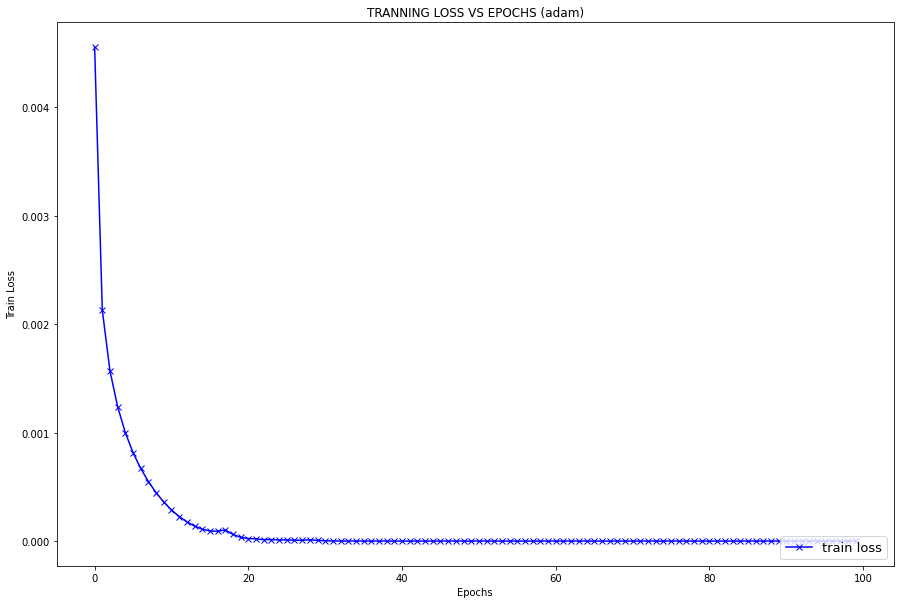

In [148]:
# Plotting Training loss vs epoch 
e = [i for i in range(mlp._num_epochs)]

plot_single_line_graph(e,mlp._train_losses,"train loss",f"TRANNING LOSS VS EPOCHS ({mlp._optimizer})" ,"Train Loss",path=data_path, filename=mlp._optimizer+'-train loss',f_size=(15,10))

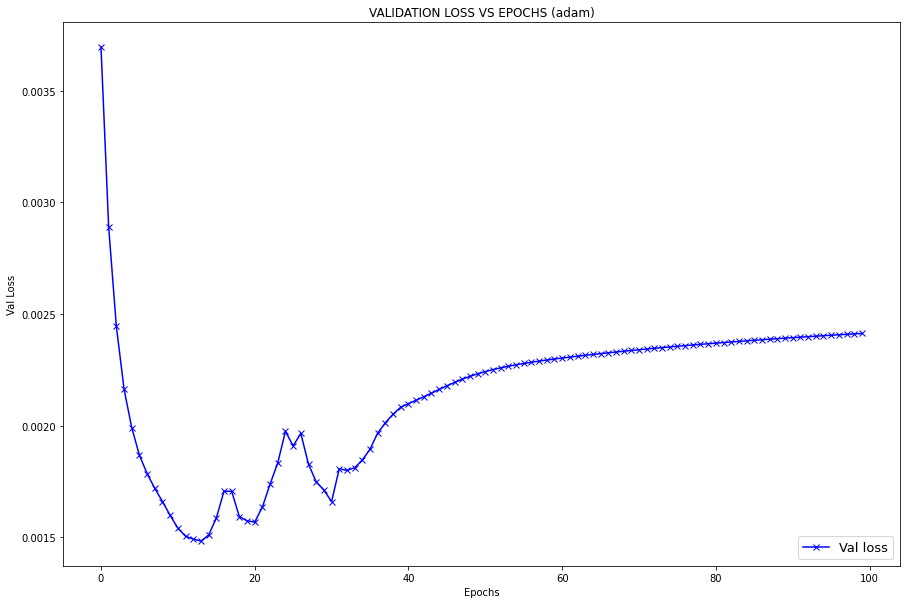

In [149]:
# Plotting Testing loss vs epoch 
plot_single_line_graph(e,mlp._test_losses,"Val loss",f"VALIDATION LOSS VS EPOCHS ({mlp._optimizer})" ,"Val Loss",path=data_path, filename=mlp._optimizer+'-val loss',f_size=(15,10))

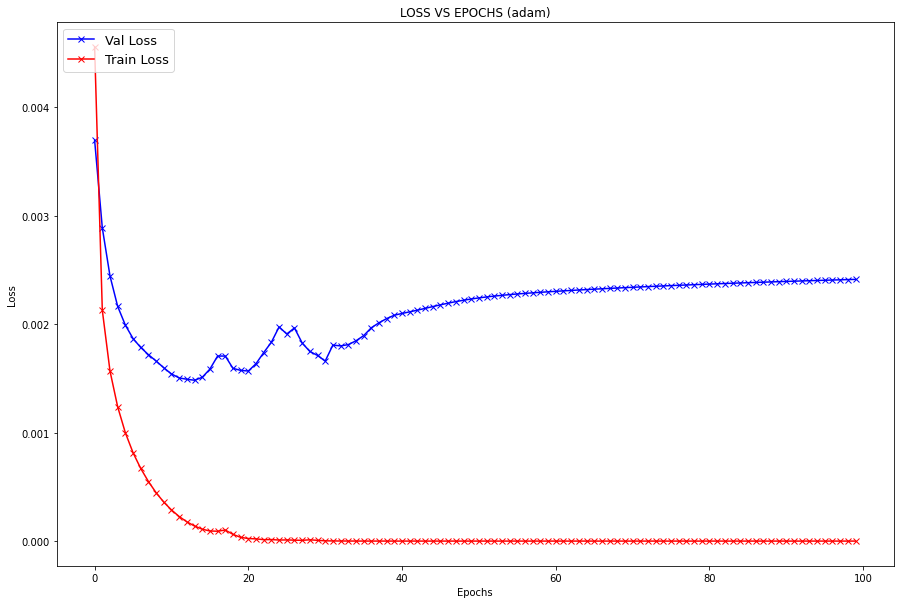

In [150]:
# Double line graph for LOSS vs Epochs 
plot_double_line_graph(e,mlp._test_losses,"Val Loss" ,e,mlp._train_losses,"Train Loss" ,f"LOSS VS EPOCHS ({mlp._optimizer})","Loss",path=data_path, filename=mlp._optimizer+'-val loss',f_size=(15,10))

In [151]:
# colors = ['darkviolet', 'crimson', 'orangered', 'darkmagenta', 'forestgreen', 'midnightblue']
# modelList = []
# e = [i for i in range(mlp._num_epochs)]
# for color, model in zip(colors, models):
#   modelList.append([model._test_acc, model._optimizer, color])

# print(len(modelList))
# #Multi line graph for LOSS vs Epochs 
# plot_multi_line_graph(e, modelList ,f"ACC VS EPOCHS (comparison)","Test Acc",path=data_path, filename='optimizers-val accuracy',f_size=(15,10))

### Accuracy vs Epochs

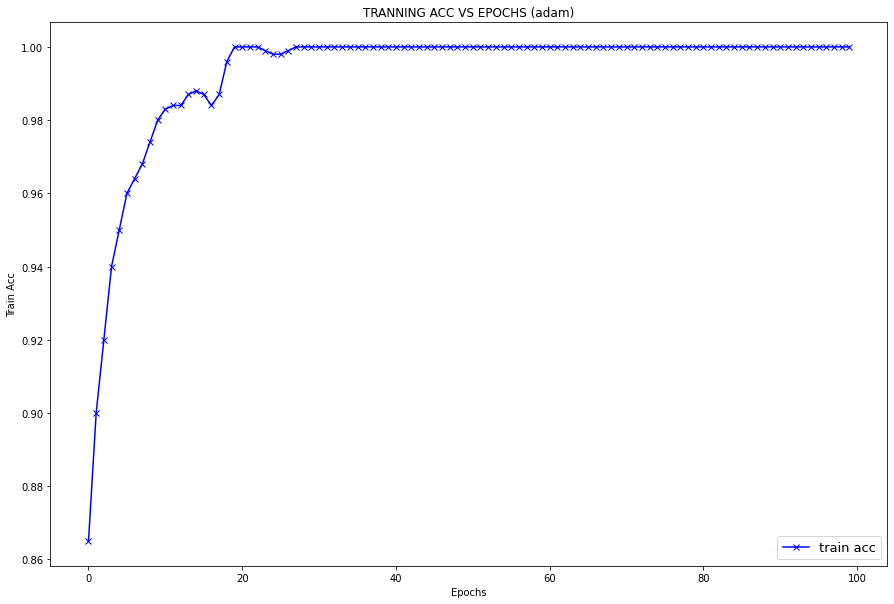

In [152]:
# Plotting Training loss vs epoch 
plot_single_line_graph(e,mlp._train_acc,"train acc",f"TRANNING ACC VS EPOCHS ({mlp._optimizer})" ,"Train Acc",path=data_path, filename=mlp._optimizer+'-train accuracy',f_size=(15,10))

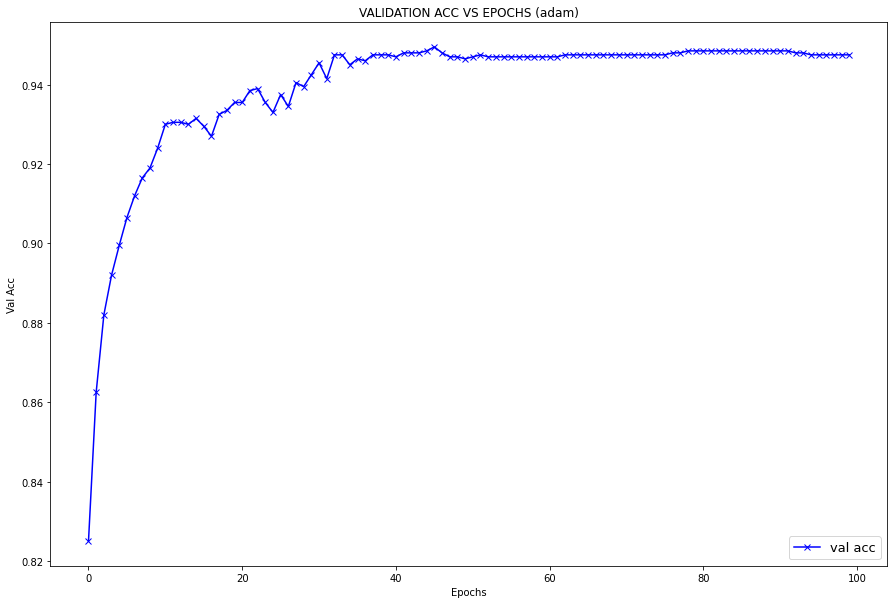

In [153]:
# Plotting Testing loss vs epoch 
plot_single_line_graph(e,mlp._test_acc,"val acc",f"VALIDATION ACC VS EPOCHS ({mlp._optimizer})" ,"Val Acc",path=data_path, filename=mlp._optimizer+'-val accuracy',f_size=(15,10))

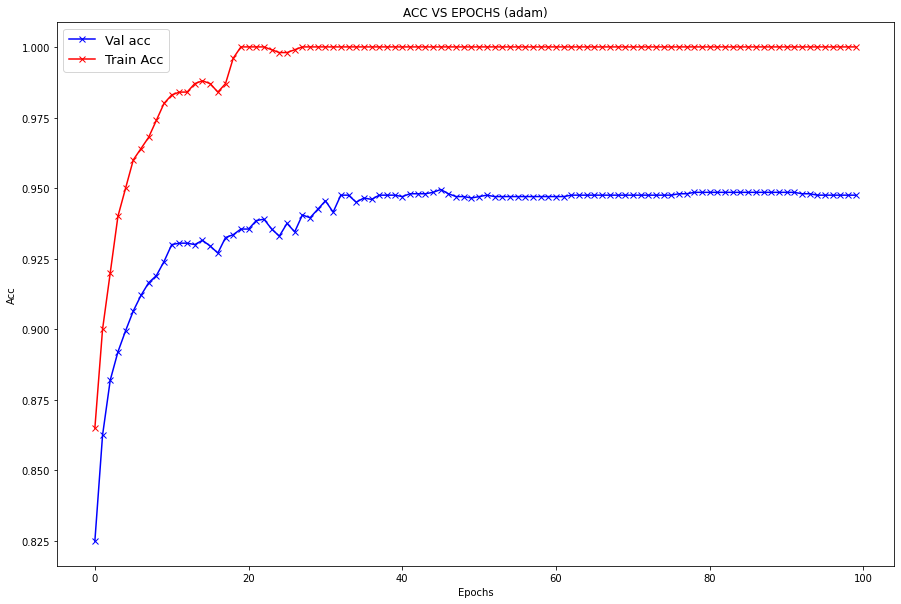

In [154]:
# Double line graph for LOSS vs Epochs 
plot_double_line_graph(e,mlp._test_acc,"Val acc" ,e,mlp._train_acc,"Train Acc" ,f"ACC VS EPOCHS ({mlp._optimizer})","Acc",path=data_path, filename=mlp._optimizer+'-val accuracy',f_size=(15,10))

### ROC curves 

<Figure size 432x288 with 0 Axes>

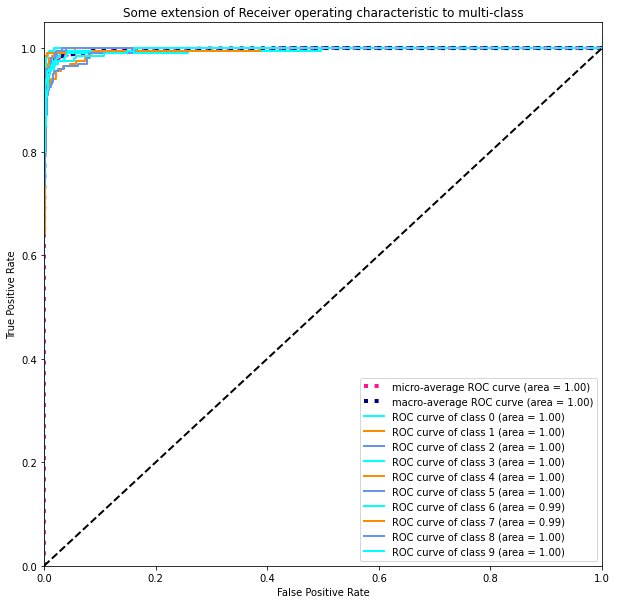

In [155]:
plot_roc([0,1,2,3,4,5,6,7,8,9], y_val, mlp.predict_proba(X_val), (10,10),path=data_path, filename=mlp._optimizer)

## Confusion Matrics 

## Test

In [156]:
conf_mat_test = confusion_matrix_find(y_val2, mlp.predict(X_val), 10)

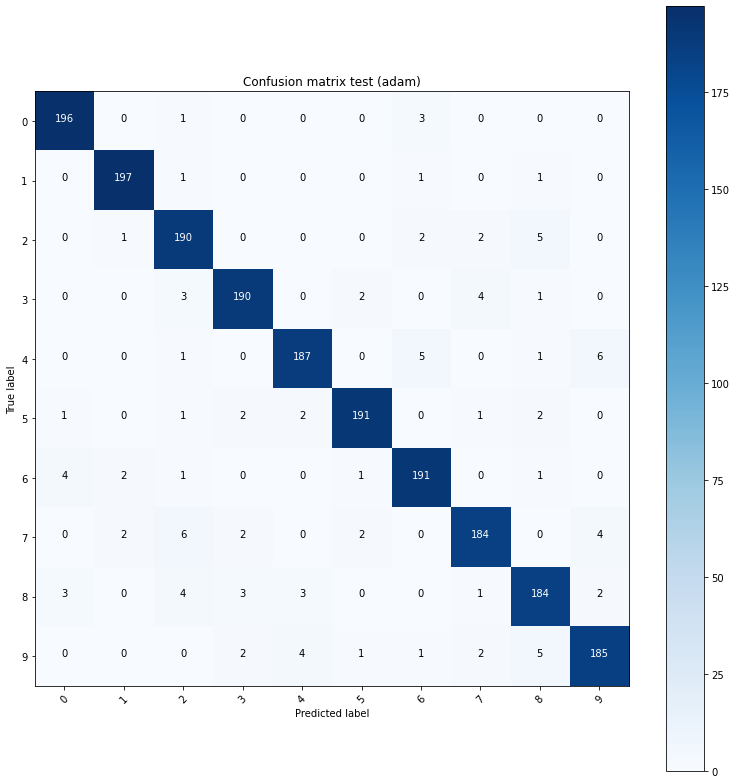

In [157]:
confusion_matrix_plot(np.array(conf_mat_test), [0,1,2,3,4,5,6,7,8,9], title=f'Confusion matrix test ({mlp._optimizer})', cmap=plt.cm.Blues, figsize=(11,11),path=data_path, filename=mlp._optimizer+'-val')

## Train 

In [158]:
conf_mat_train = confusion_matrix_find(y_train2, mlp.predict(X_train), 10)

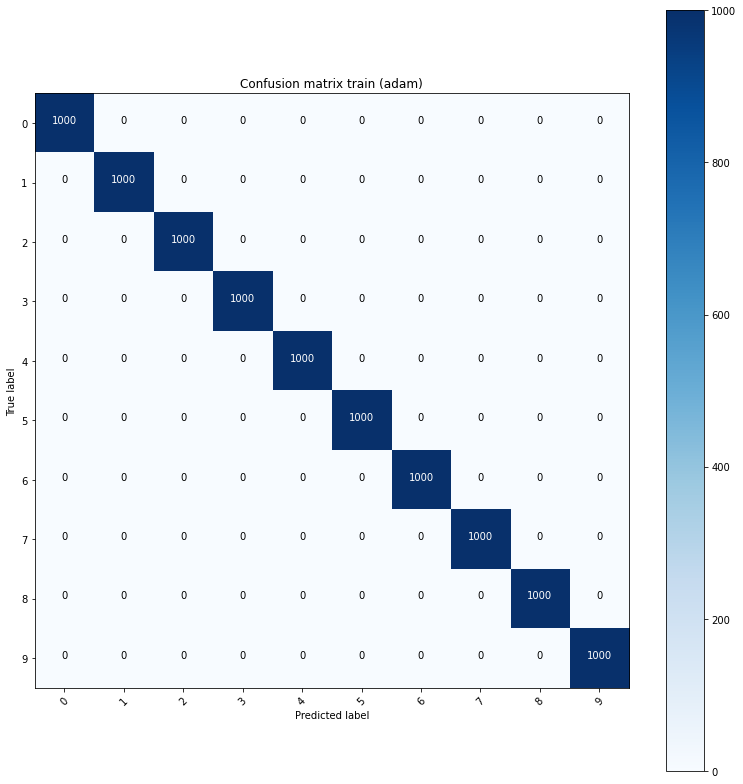

In [159]:
confusion_matrix_plot(np.array(conf_mat_train), [0,1,2,3,4,5,6,7,8,9], title=f'Confusion matrix train ({mlp._optimizer})', cmap=plt.cm.Blues, figsize=(11,11),path=data_path, filename=mlp._optimizer+'-train')